# 环境搭建和基本class实现

In [3]:
# Import necessary modules
import os
import gc
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import gymnasium as gym
from agent.base_agent import BaseAgent
from utils import seed_everything

/usr/local/lib/python3.10/dist-packages/torch/_subclasses/functional_tensor.py:267: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem .

In [13]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment setup
# 调用python的垃圾回收器，减少内存占用，帮助防止内存泄漏
gc.collect()
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Set CUDA launch blocking to 1 for debugging CUDA-related errors


# Replay Buffer Class
# 存储和管理竟会回访缓冲区，保存了智能体和环境交互的状态，动作等信息，
# 并提供了存储和随机采样这些经验的方法，以便在训练过程中使用
class ReplayBuffer:
    def __init__(self, capacity):
        """
        Experience replay buffer used to store transitions
        """
        self.capacity = capacity
        # 缓冲区达到最大容量时，新元素将会替代旧元素
        self.buffer = deque(maxlen=capacity)

    def store(self, state, action, next_state, reward, done):
        """
        Store a transition in the buffer
        """
        self.buffer.append((state, action, next_state, reward, done))

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer
        
        """
        indices = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        # *用于解包，zip用于叭同类型组合
        states, actions, next_states, rewards, dones = zip(*(self.buffer[idx] for idx in indices))

        # Convert sampled transitions to tensors
        states = torch.stack(states).to(device)
        actions = torch.tensor(actions, dtype=torch.long, device=device)
        next_states = torch.stack(next_states).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.bool, device=device)

        return states, actions, next_states, rewards, dones
    # 属性访问器
    def __len__(self):
        return len(self.buffer)

class Qnet(nn.Module):
    def __init__(self, num_actions, input_dim):
        """
        Neural network for Deep Q-Learning
        """
        # super函数是内置函数，用于调用父类的方法，并进行初始化，
        # 确保创建Qnet实例时所有功能可以正常工作
        super(Qnet, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_actions)
        )
        self._initialize_weights()

    def forward(self, x):
        """
        Forward pass through the network
        """
        return self.fc_layers(x)


    def _initialize_weights(self):
        """
        Initialize weights for linear layers using Kaiming uniform initialization
        """
        for layer in self.fc_layers:
            # 对于每一层检查是否是线性层
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')


In [23]:
# DQN Agent Class inheriting from Agent
class DQNAgent(BaseAgent):
    def __init__(self, env, hyperparams):
        """
        DQN Agent class for interacting with the environment and learning
        """
        super(DQNAgent, self).__init__(env, hyperparams)
        self.replay_memory = ReplayBuffer(hyperparams['memory_capacity'])

        # Main and target networks
        # 创建主网络和目标网络的实例
        # 调用to(device)移动到指定设备，使主网络和目标网络可以在不同时间步长上更新
        # 主网络用于实际的Q值预测
        # 目标网络用于计算稳定的目标Q值
        self.model = Qnet(self.num_actions, self.state_dim).to(device)
        self.target_network = Qnet(self.num_actions, self.state_dim).to(device)
        # 主网络的权重复制到目标网络中，保持目标网络稳定性
        # 防止目标值频繁变化
        self.update_target_network()

        # Optimizer and loss function
        self.optimizer = optim.Adam(self.model.parameters(), lr=hyperparams['learning_rate'])
        self.criterion = nn.MSELoss()
        
        # Additional hyperparameters
        self.discount = hyperparams['discount_factor']
        self.epsilon = hyperparams['epsilon_max']
        self.epsilon_min = hyperparams['epsilon_min']
        self.epsilon_decay = hyperparams['epsilon_decay']
        self.epsilon_history = []
        self.clip_grad_norm = hyperparams['clip_grad_norm']
        self.loss_history = []
        self.running_loss = 0
        self.learned_counts = 0

    def select_action(self, state):
        """
        Select an action using epsilon-greedy policy
        """
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        with torch.no_grad():
            Q_values = self.model(state)
            return torch.argmax(Q_values).item()

    def learn(self, batch_size, done):
        """
        Learn from a batch of experiences using the DQN update rule
        """
        # Sample a batch from the replay buffer
        states, actions, next_states, rewards, dones = self.replay_memory.sample(batch_size)
        actions = actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)
        # Compute predicted Q-values and target Q-values
        predicted_q = self.model(states).gather(dim=1, index=actions)
        with torch.no_grad():
            # use main network to select best action
            best_actions = self.model(next_states).argmax(dim=1, keepdim=True)
            # use target nerwork to evaluate the best action
            next_target_q_value = self.target_network(next_states).gather(1,best_actions)
            next_target_q_value[dones] = 0
            # compute target q value
            y_js = rewards + (self.discount * next_target_q_value)
        # Compute loss
        loss = self.criterion(predicted_q, y_js)
        self.running_loss += loss.item()
        self.learned_counts += 1
        if done:
            self.loss_history.append(self.running_loss / self.learned_counts)
            self.running_loss, self.learned_counts = 0, 0
        # Backpropagate the loss
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)
        self.optimizer.step()

    def update_target_network(self):
        """
        Update the target network by copying weights from the main network
        """
        self.target_network.load_state_dict(self.model.state_dict())

    def update_epsilon(self):
        """
        Update epsilon value for epsilon-greedy policy
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.epsilon_history.append(self.epsilon)
    def save(self, path):
        """
        Save the trained model
        """
        torch.save(self.model.state_dict(), path)
    
    def load(self, path):
        """
        Load the trained model
        """
        self.model.load_state_dict(torch.load(path, map_location=device))


In [24]:
# Trainer Class
class Trainer:
    def __init__(self, env, agent, hyperparams):
        """
        Trainer class to manage training and evaluation of the agent
        """
        self.env = env
        self.agent = agent
        self.hyperparams = hyperparams
        self.reward_history = []
        self.step_history = []
        if hasattr(agent, 'replay_memory'):
            self.use_replay_memory = True
        else:
            self.use_replay_memory = False

    def state_preprocess(self, state):
        """
        Convert the state to one-hot representation 
        """
        onehot_vector = torch.zeros(self.env.observation_space.n, dtype=torch.float32, device=device)
        onehot_vector[state] = 1
        return onehot_vector
    def train(self):
        """
        Train the agent for a specified number of episodes
        """
        print(f"train with episodes: {self.hyperparams['max_episodes']}")
        total_steps = 0
        for episode in range(1, self.hyperparams['max_episodes'] + 1):
            state, _ = self.env.reset(seed=seed)
            state = self.state_preprocess(state)
            done, truncation = False, False
            step_size, episode_reward = 0, 0

            while not done and not truncation:
                # Select and execute an action
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)
                next_state = self.state_preprocess(next_state)

                # use ReplayBuffer
                if self.use_replay_memory:
                    self.agent.replay_memory.store(state, action, next_state, reward, done)
                    if len(self.agent.replay_memory) > self.hyperparams['batch_size'] and sum(self.reward_history) > 0:
                        self.agent.learn(self.hyperparams['batch_size'], (done or truncation))
                        # Update target network periodically
                        if total_steps % self.hyperparams['update_frequency'] == 0:
                            self.agent.update_target_network()

                state = next_state
                episode_reward += reward
                step_size += 1

            self.reward_history.append(episode_reward)
            self.step_history.append(step_size)  # Track steps for each episode
            total_steps += step_size
            self.agent.update_epsilon()

            # Save the model at specified intervals
            if episode % self.hyperparams['save_interval'] == 0:
                os.makedirs(self.hyperparams['model_dir'], exist_ok=True)
                self.agent.save(os.path.join(self.hyperparams['model_dir'], f'{episode}.pth'))
                print('\n~~~~~~Interval Save: Model saved.\n')
            # Print episode information at specified intervals
            if episode % self.hyperparams['print_interval'] == 0:
                print(f"Episode: {episode}, Total Steps: {total_steps}, Ep Step: {step_size}, Raw Reward: {episode_reward:.2f}, Epsilon: {self.agent.epsilon:.2f}")
        self.plot_training(episode)

    def test(self, max_episodes=None):
        """
        Test the trained agent
        """
        # Load the trained model
        self.agent.load(os.path.join(self.hyperparams['model_dir'], f"{self.hyperparams['train_episodes']}.pth"))
        self.agent.model.eval()

        if max_episodes is None:
            max_episodes = self.hyperparams['max_episodes']

        for episode in range(1, max_episodes + 1):
            state, _ = self.env.reset(seed=seed)
            done, truncation = False, False
            step_size, episode_reward = 0, 0

            while not done and not truncation:
                # Select an action
                state = self.state_preprocess(state)
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)
                state = next_state
                episode_reward += reward
                step_size += 1

            # Print episode information
            print(f"Episode: {episode}, Steps: {step_size}, Reward: {episode_reward:.2f}")


    def plot_training(self, episode):
        """
        Plot the training reward history, loss history, and step convergence
        """
        # Plot Rewards
        sma = np.convolve(self.reward_history, np.ones(50)/50, mode='valid')
        plt.figure()
        plt.title("Rewards")
        plt.plot(self.reward_history, label='Raw Reward', color='#F6CE3B', alpha=1)
        plt.plot(sma, label='SMA 50', color='#385DAA')
        plt.xlabel("Episode")
        plt.ylabel("Rewards")
        plt.legend()
        if episode == self.hyperparams['max_episodes']:
            os.makedirs(self.hyperparams['plot_dir'], exist_ok=True)
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'reward_plot.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()

        # Plot Loss
        plt.figure()
        plt.title("Loss")
        plt.plot(self.agent.loss_history, label='Loss', color='#CB291A', alpha=1)
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        if episode == self.hyperparams['max_episodes']:
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'loss_plot.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()
        # Plot Epsilon
        plt.figure()
        plt.title("Epsilon", fontweight='bold')
        plt.plot(self.agent.epsilon_history, label='Epsilon', color='#FF5733', alpha=1)
        plt.xlabel("Episode")
        plt.ylabel("Epsilon")
        plt.legend()
        if episode == self.hyperparams['max_episodes']:
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'epsilon_plot.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()
        


## 运行程序

In [27]:
# Main Function to Set Up and Train/Test the Model
if __name__ == "__main__":
    method_name = "double_dqn"  # 修改方法名称为 double_dqn
    train_mode = True
    render = not train_mode
    map_size = 4  # Start with 4x4 map
    seed = 1

    # Build config
    config = {
         "train_mode": train_mode,
        "method_name": method_name,
        "model_dir": f'output/{method_name}/model/{map_size}x{map_size}/',
        "plot_dir": f'output/{method_name}/plt/{map_size}x{map_size}/',
        "save_interval": 500,
        "print_interval": 100,
        "clip_grad_norm": 3,
        "learning_rate": 6e-4,
        "discount_factor": 0.93,
        "batch_size": 32,
        "update_frequency": 10,
        "max_episodes": 10000 if train_mode else 10,
        "train_episodes": 10000,
        "max_steps": 200,
        "render": render,
        "epsilon_max": 0.999 if train_mode else -1,
        "epsilon_min": 0.01,
        "epsilon_decay": 0.999,
        "memory_capacity": 4000 if train_mode else 0,
        "map_size": map_size,
        "render_fps": 6,
    }

    # Seed everything for reproducibility
    seed_everything(seed)

    # Create environment
    env = gym.make(
        'FrozenLake-v1', 
        map_name=f"{config['map_size']}x{config['map_size']}", 
        is_slippery=True, 
        max_episode_steps=config['max_steps'],
        render_mode="human" if config['render'] else None
    )
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.metadata['render_fps'] = config['render_fps']
    # Create agent and trainer
    agent = DQNAgent(env, config)
    trainer = Trainer(env, agent, config)


Episode: 100, Total Steps: 697, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1418, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2251, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3019, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3815, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4605, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5318, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6030, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 6736, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7509, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8311, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.33
Episode: 1200, Total Steps: 9111, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.30
Ep

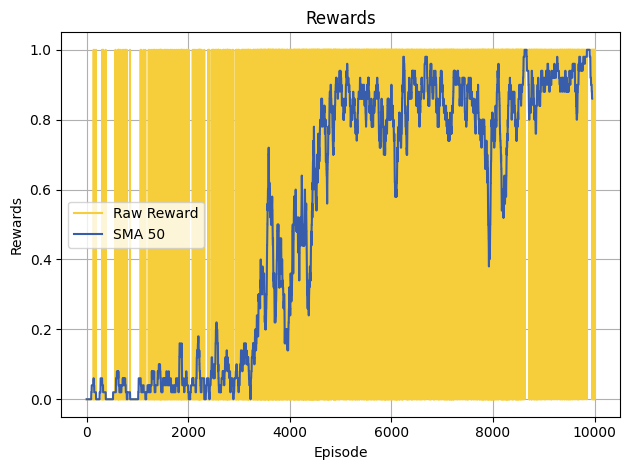

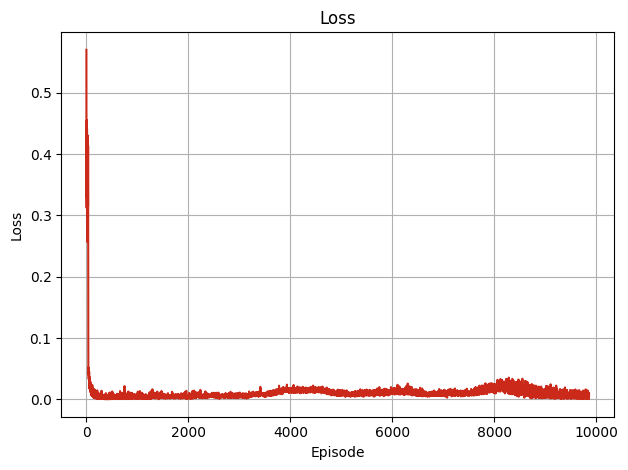

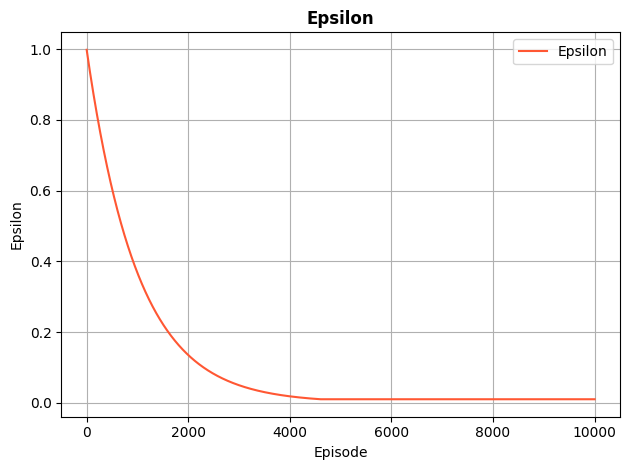

In [15]:
# Train or test
if config['train_mode']:
    trainer.train()
else:
    trainer.test()

## 参数调整

In [2]:
# 定义参数分析函数，主要针对
# 回合数（train_episodes ），
# 学习率（learning_rate）、
# 折扣因子（discount_factor）、
# epsilon-greedy 策略中的参数
# （epsilon_max, epsilon_min, epsilon_decay）

# 分析函数的实现，方便多次调用
def Analysis(train_episodes,learning_rate, discount_factor):
    # 非分析参数定义
    method_name = "dqn"
    train_mode = True
    train_episodes = train_episodes
    render = not train_mode
    map_size = 4
    seed = 1
    # build config
    config = {
        "train_mode": train_mode,
        "method_name": method_name,
        "model_dir": f'output/{method_name}/model/{map_size}x{map_size}/',
        "plot_dir": f'output/{method_name}/plt/{map_size}x{map_size}/',
        "save_interval": 500,
        "print_interval": 100,
        "clip_grad_norm": 3,
        "learning_rate": learning_rate,
        "discount_factor": discount_factor,
        # First
        "batch_size": 32,
        # Second
        "update_frequency": 10,
        "max_episodes": train_episodes if train_mode else 10,
        "train_episodes": train_episodes,
        "max_steps": 200,
        "render": render,
        "epsilon_max": 0.999 if train_mode else -1,
        "epsilon_min": 0.01,
        "epsilon_decay": 0.999,
        # Third
        "memory_capacity": 4000 if train_mode else 0,
        "map_size": map_size,
        "render_fps": 6,
    }

    # set seed
    seed_everything(seed)
    # Create environment
    env = gym.make(
        'FrozenLake-v1', 
        map_name=f"{config['map_size']}x{config['map_size']}", 
        is_slippery=True, 
        max_episode_steps=config['max_steps'], 
        render_mode="human" if config['render'] else None)

    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.metadata['render_fps'] = config['render_fps']

    # Create agent and trainer
    agent = DQNAgent(env, config)
    trainer = Trainer(env, agent, config)
    # Train or test
    if config['train_mode']:
        trainer.train()
    else:
        trainer.test() 



## 超参数调优

Traning with hyperparams: {'train_episodes': 2000, 'learning_rate': 0.0003, 'discount_factor': 0.9}
Episode: 100, Total Steps: 797, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1506, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2277, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3061, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3726, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4401, Ep Step: 12, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5111, Ep Step: 21, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 5937, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 6611, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7310, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 7983, Ep Step: 3, Raw Reward

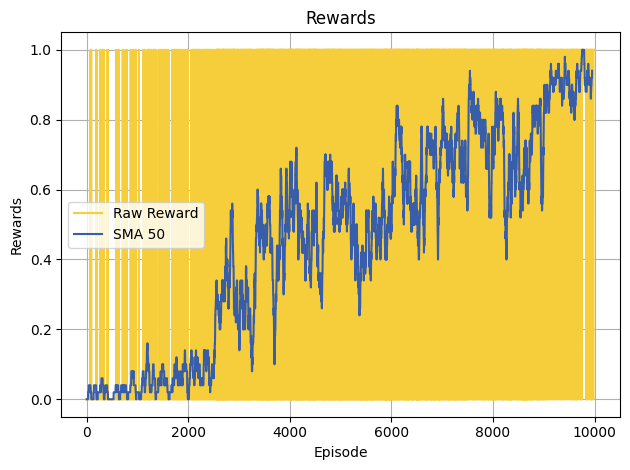

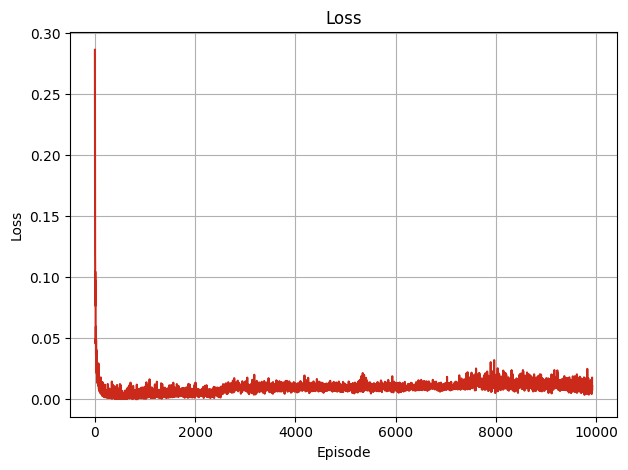

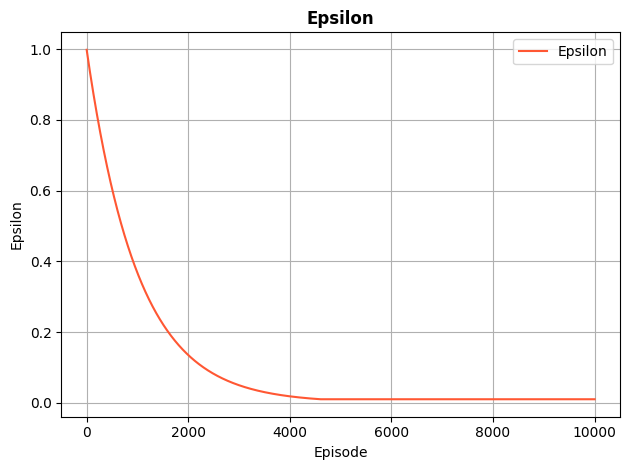

Traning with hyperparams: {'train_episodes': 2000, 'learning_rate': 0.0003, 'discount_factor': 0.95}
Episode: 100, Total Steps: 770, Ep Step: 12, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1525, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2267, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3003, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3921, Ep Step: 15, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4723, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5488, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6260, Ep Step: 14, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 7023, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7771, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8760, Ep Step: 3, Raw Rewa

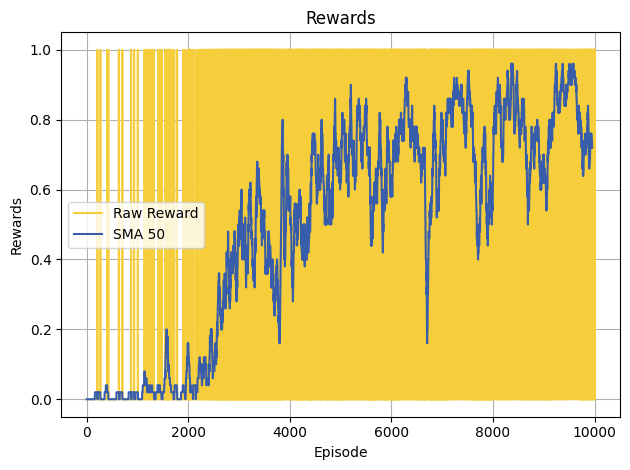

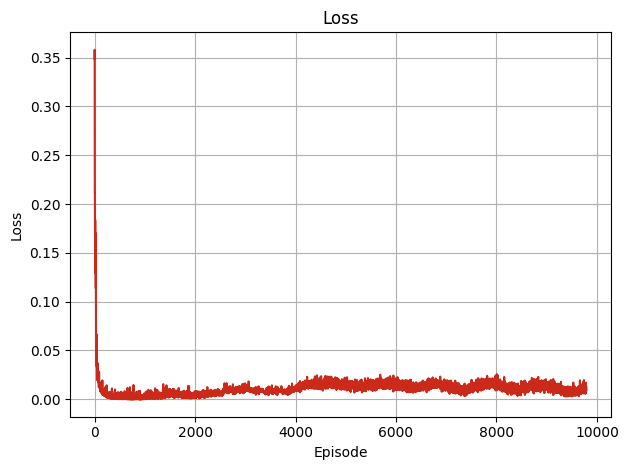

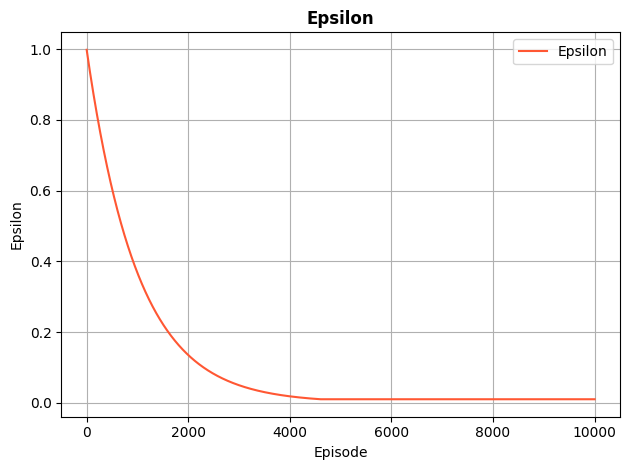

Traning with hyperparams: {'train_episodes': 2000, 'learning_rate': 0.0003, 'discount_factor': 0.97}
Episode: 100, Total Steps: 735, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1516, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2287, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 2986, Ep Step: 18, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3868, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4679, Ep Step: 14, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5445, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6231, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 7042, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7895, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8798, Ep Step: 8, Raw Rewa

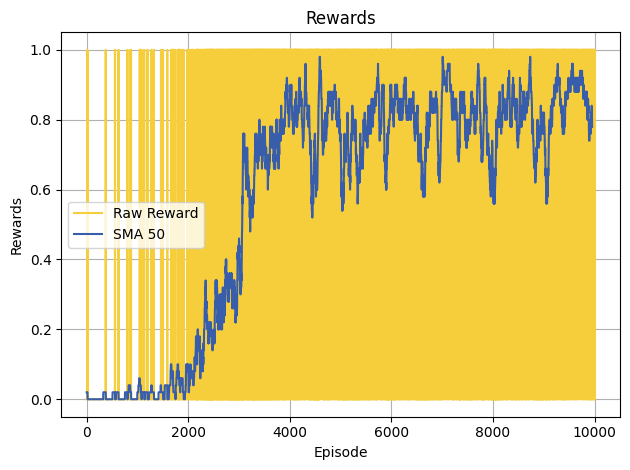

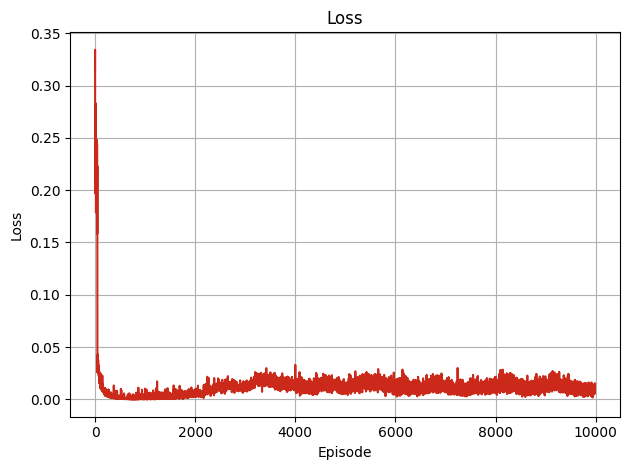

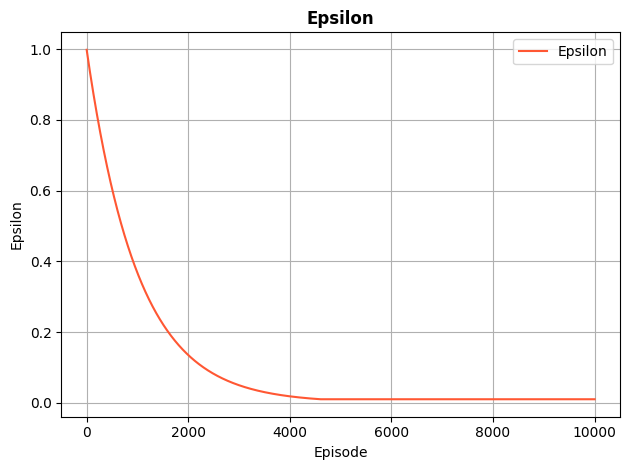

Traning with hyperparams: {'train_episodes': 2000, 'learning_rate': 0.001, 'discount_factor': 0.9}
Episode: 100, Total Steps: 688, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1497, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2287, Ep Step: 15, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 2998, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3712, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4533, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5285, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 5988, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 6853, Ep Step: 27, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7716, Ep Step: 13, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8608, Ep Step: 7, Raw Reward

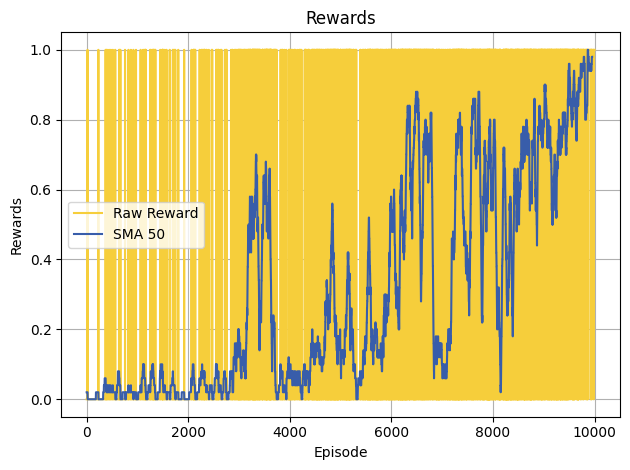

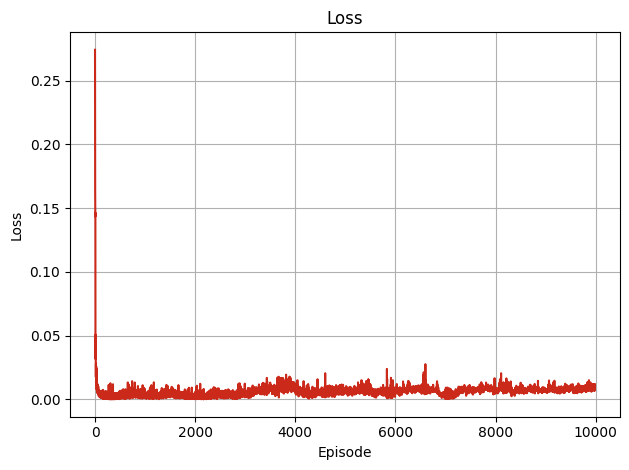

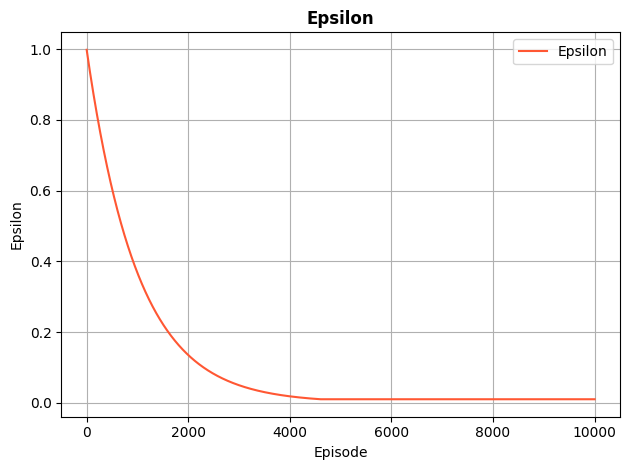

Traning with hyperparams: {'train_episodes': 2000, 'learning_rate': 0.001, 'discount_factor': 0.95}
Episode: 100, Total Steps: 720, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1445, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2208, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3100, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3960, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4859, Ep Step: 20, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5621, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6452, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 7264, Ep Step: 17, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 8063, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8863, Ep Step: 5, Raw Rewa

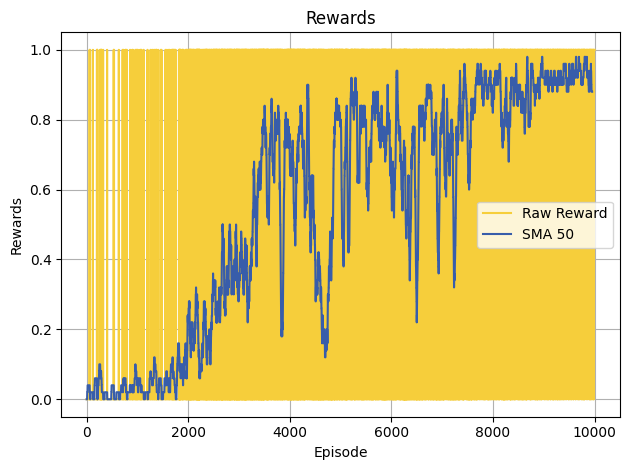

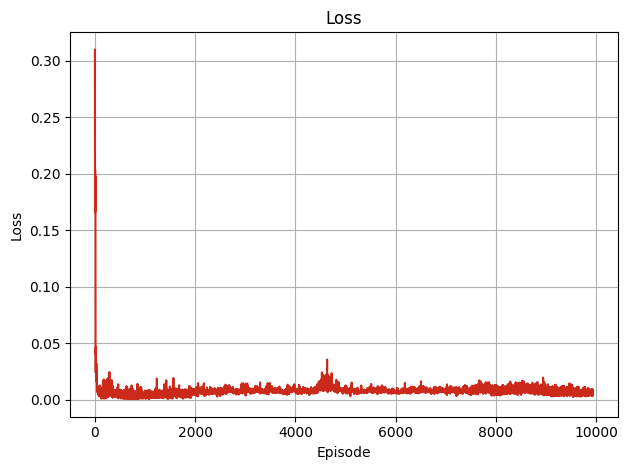

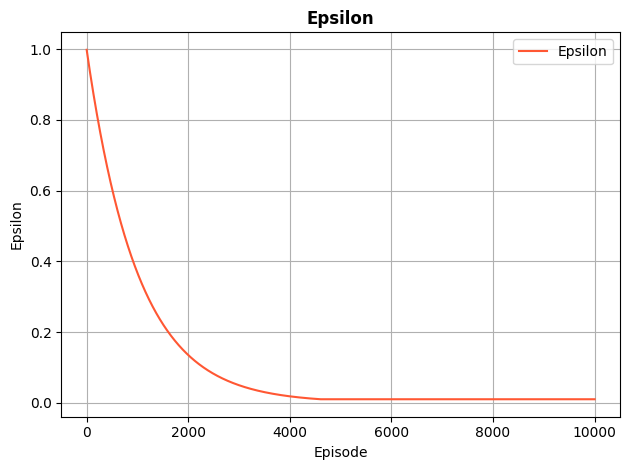

Traning with hyperparams: {'train_episodes': 2000, 'learning_rate': 0.001, 'discount_factor': 0.97}
Episode: 100, Total Steps: 705, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1451, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2253, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3084, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3873, Ep Step: 16, Raw Reward: 1.00, Epsilon: 0.61
Episode: 600, Total Steps: 4642, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5503, Ep Step: 15, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6850, Ep Step: 15, Raw Reward: 1.00, Epsilon: 0.45
Episode: 900, Total Steps: 7874, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 9000, Ep Step: 16, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 10280, Ep Step: 7, Raw Re

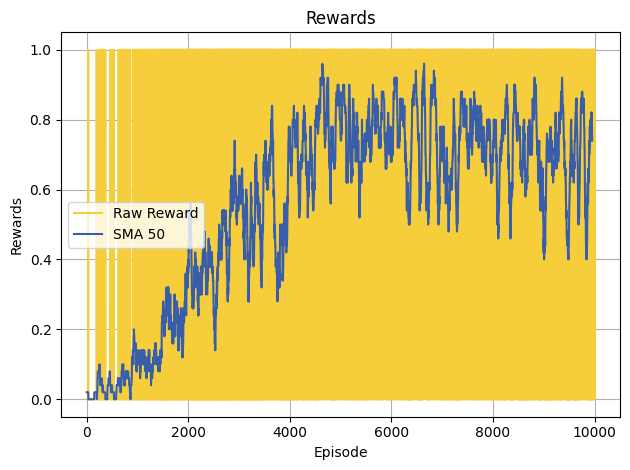

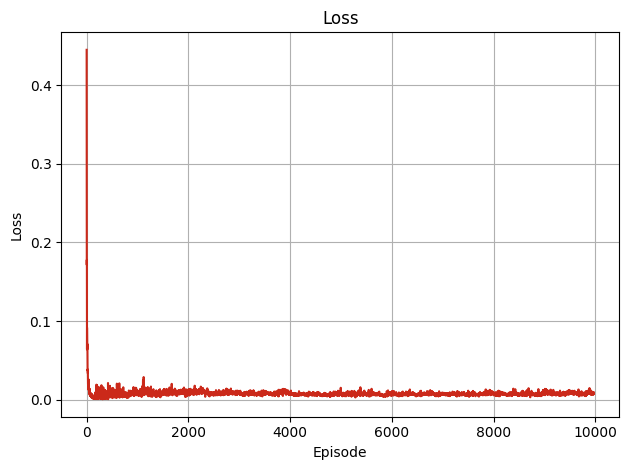

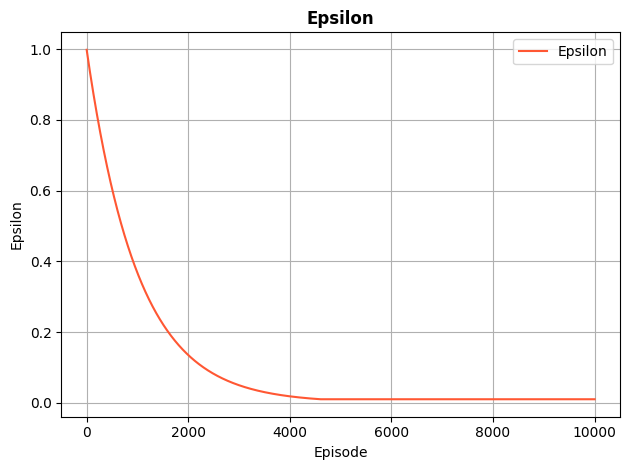

Traning with hyperparams: {'train_episodes': 2000, 'learning_rate': 0.01, 'discount_factor': 0.9}
Episode: 100, Total Steps: 739, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1587, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2348, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3102, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3837, Ep Step: 20, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4586, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5414, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6163, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 6905, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7728, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8656, Ep Step: 2, Raw Reward: 0

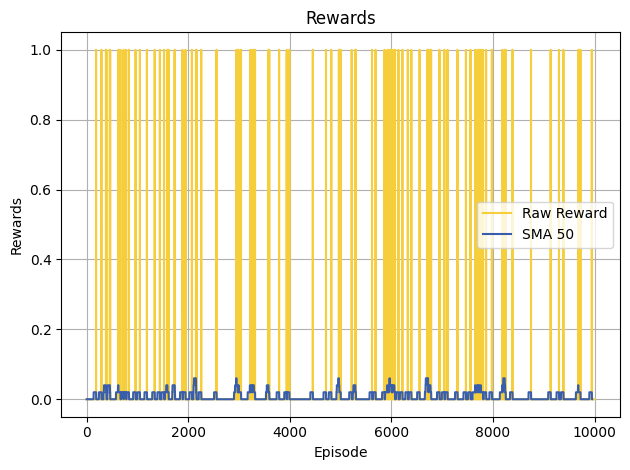

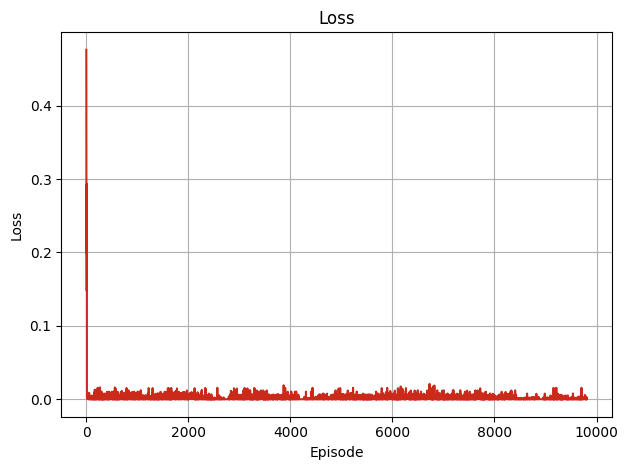

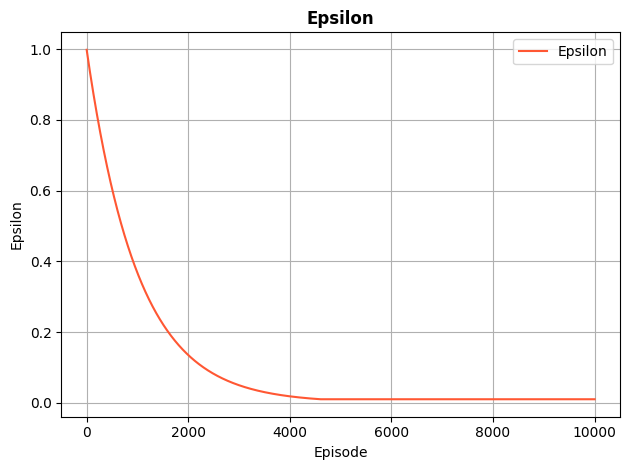

Traning with hyperparams: {'train_episodes': 2000, 'learning_rate': 0.01, 'discount_factor': 0.95}
Episode: 100, Total Steps: 693, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1430, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2206, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3047, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3905, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4760, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5615, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6599, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 7374, Ep Step: 17, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 8316, Ep Step: 11, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 9377, Ep Step: 6, Raw Reward:

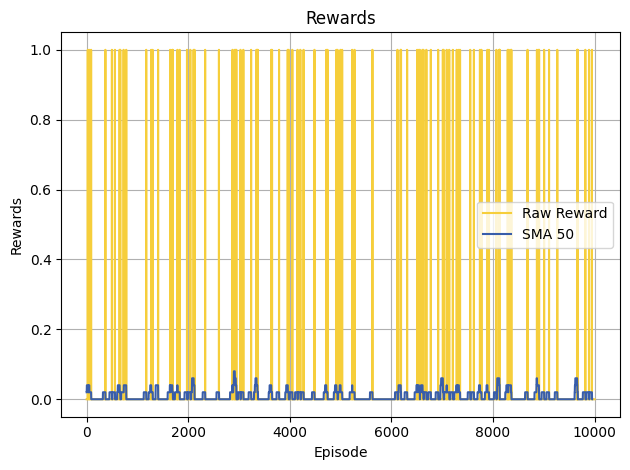

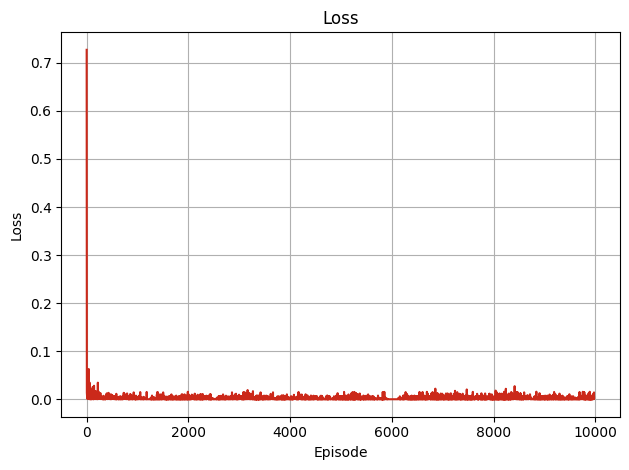

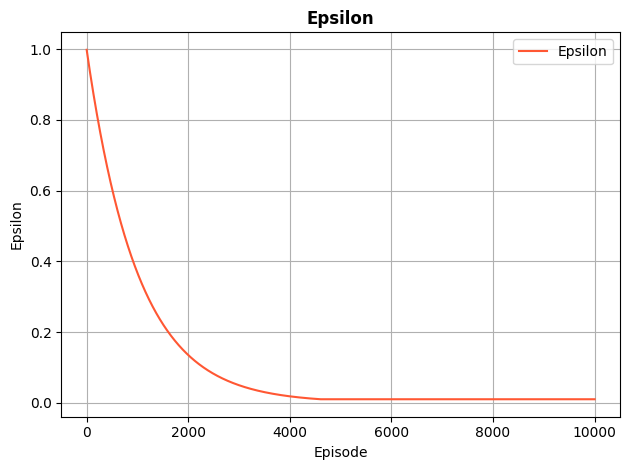

Traning with hyperparams: {'train_episodes': 2000, 'learning_rate': 0.01, 'discount_factor': 0.97}
Episode: 100, Total Steps: 739, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1507, Ep Step: 14, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2276, Ep Step: 14, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3087, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3934, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4788, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5665, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6523, Ep Step: 12, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 7423, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 8176, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 9019, Ep Step: 22, Raw Rewar

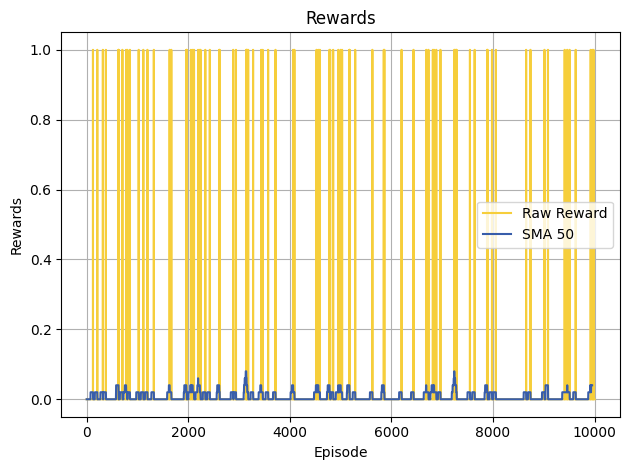

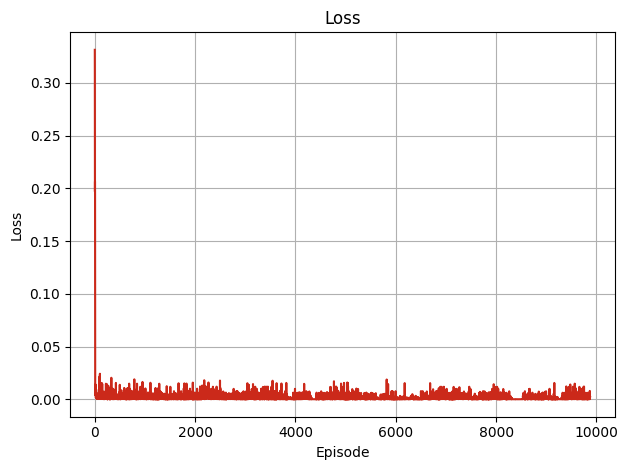

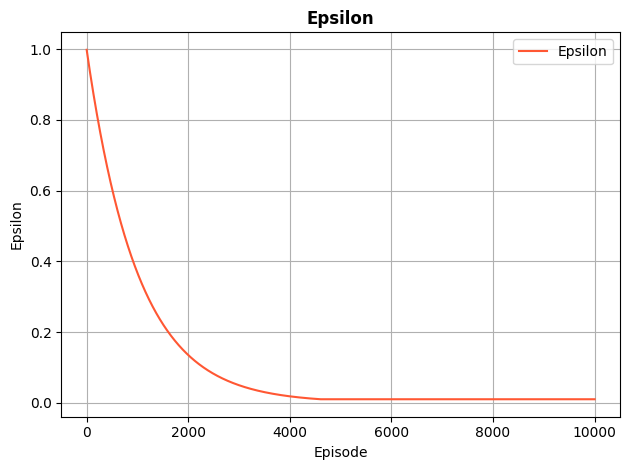

Traning with hyperparams: {'train_episodes': 5000, 'learning_rate': 0.0003, 'discount_factor': 0.9}
Episode: 100, Total Steps: 751, Ep Step: 13, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1513, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2138, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 2866, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3512, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4246, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 4960, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 5749, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 6391, Ep Step: 12, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7115, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 7909, Ep Step: 5, Raw Rewar

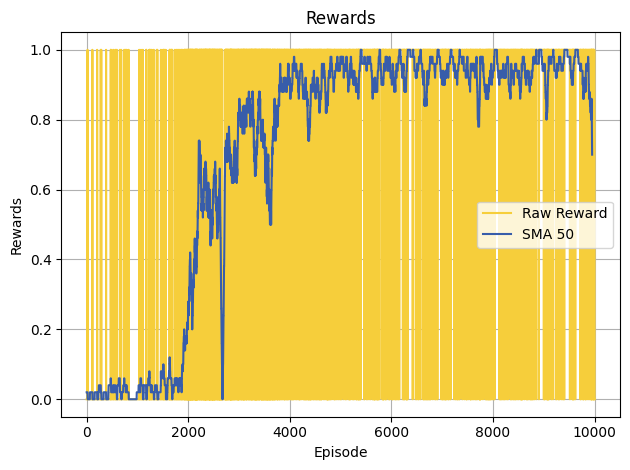

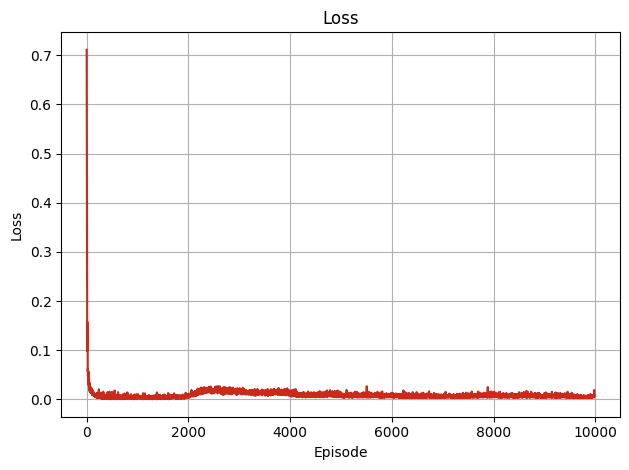

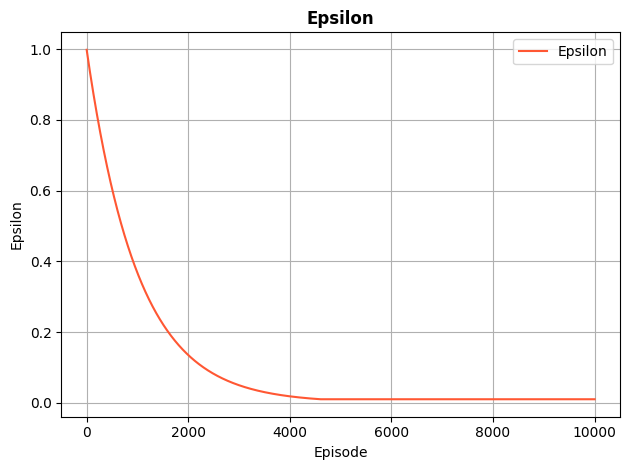

Traning with hyperparams: {'train_episodes': 5000, 'learning_rate': 0.0003, 'discount_factor': 0.95}
Episode: 100, Total Steps: 819, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1620, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2357, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3178, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3978, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4794, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5528, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6393, Ep Step: 20, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 7098, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7875, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8703, Ep Step: 4, Raw Rewar

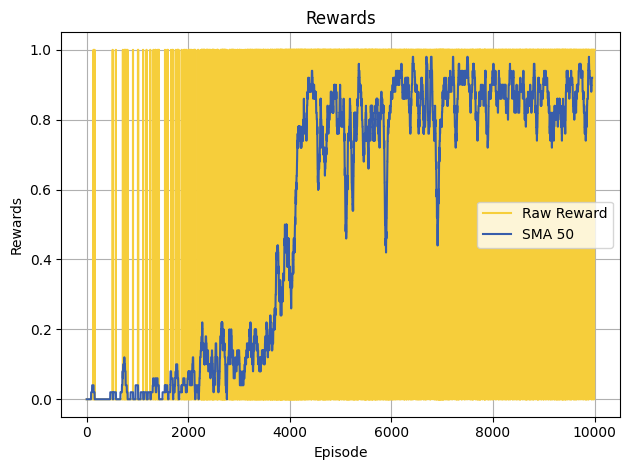

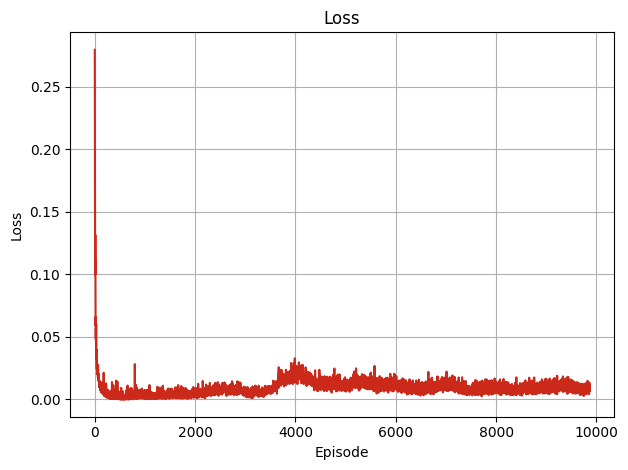

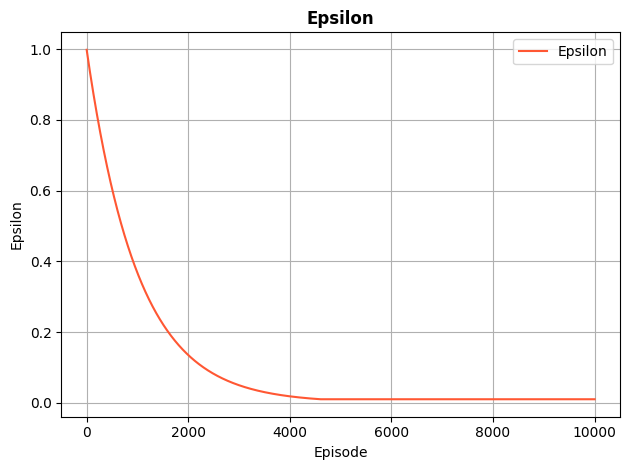

Traning with hyperparams: {'train_episodes': 5000, 'learning_rate': 0.0003, 'discount_factor': 0.97}
Episode: 100, Total Steps: 700, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1438, Ep Step: 14, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2251, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3025, Ep Step: 16, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3837, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4598, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5348, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6051, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 6857, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7678, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8436, Ep Step: 15, Raw Rew

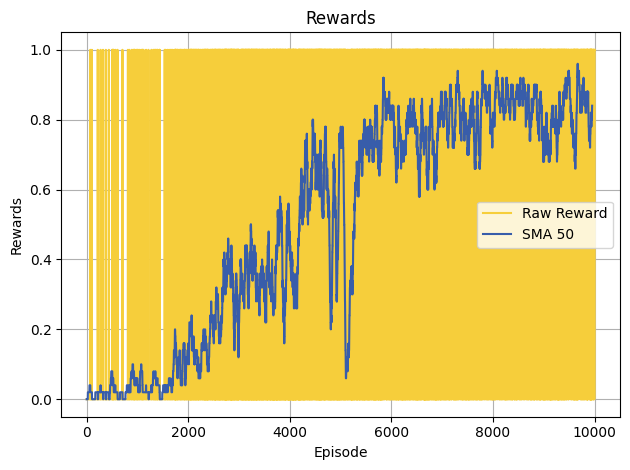

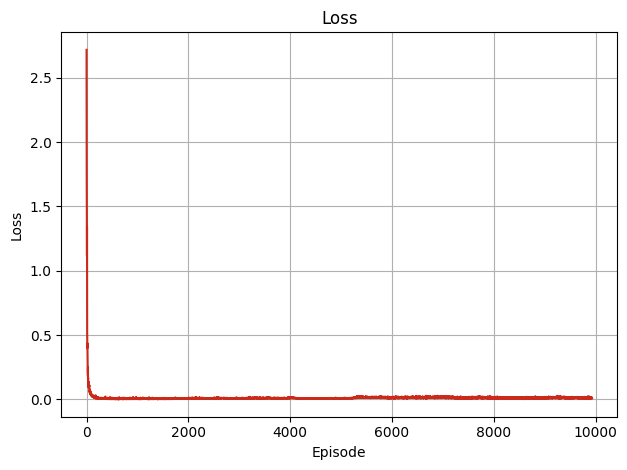

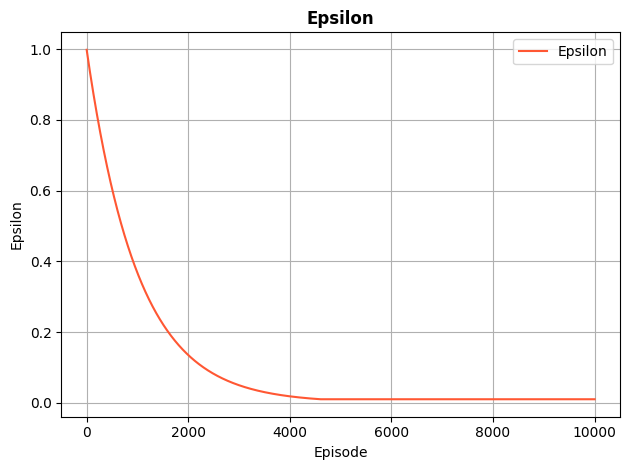

Traning with hyperparams: {'train_episodes': 5000, 'learning_rate': 0.001, 'discount_factor': 0.9}
Episode: 100, Total Steps: 753, Ep Step: 11, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1577, Ep Step: 13, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2357, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3090, Ep Step: 11, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3879, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4723, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5499, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6249, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 7075, Ep Step: 11, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 8060, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8998, Ep Step: 24, Raw Rew

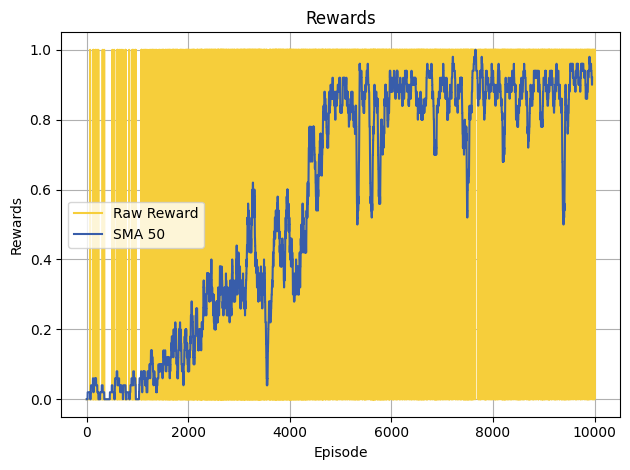

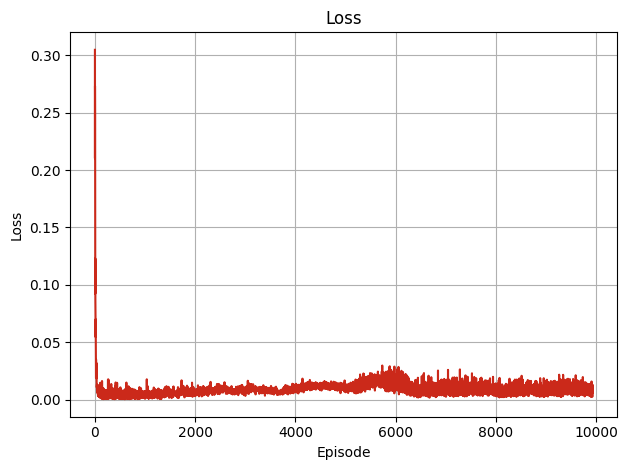

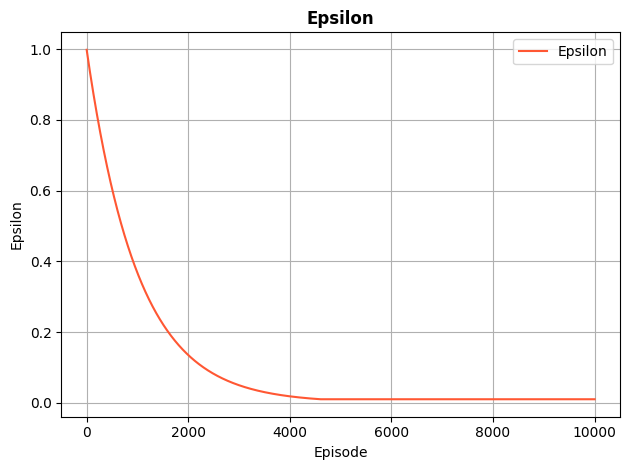

Traning with hyperparams: {'train_episodes': 5000, 'learning_rate': 0.001, 'discount_factor': 0.95}
Episode: 100, Total Steps: 734, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1482, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2266, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3028, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3799, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4615, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5396, Ep Step: 15, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6211, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 7012, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7888, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8678, Ep Step: 6, Raw Reward:

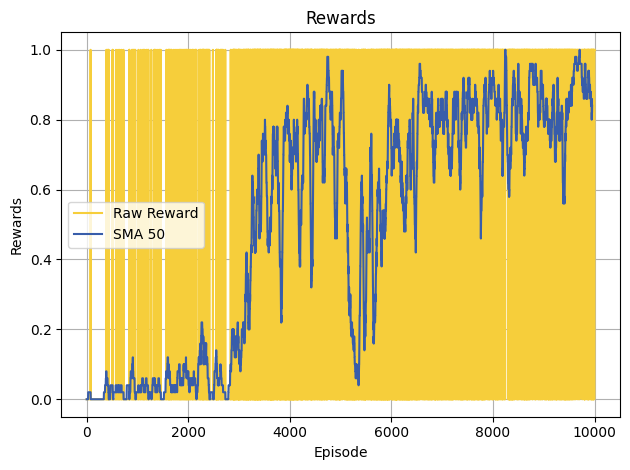

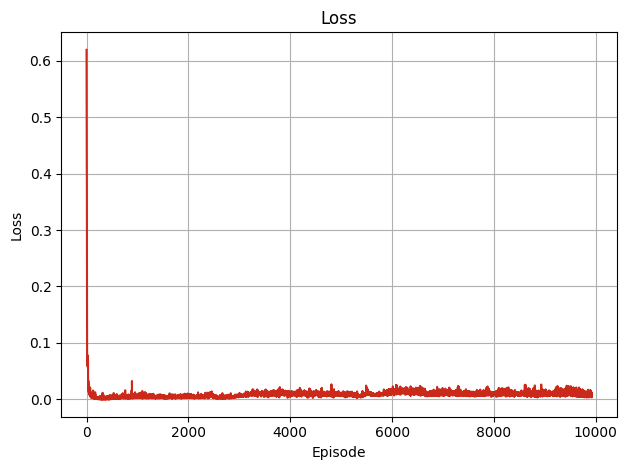

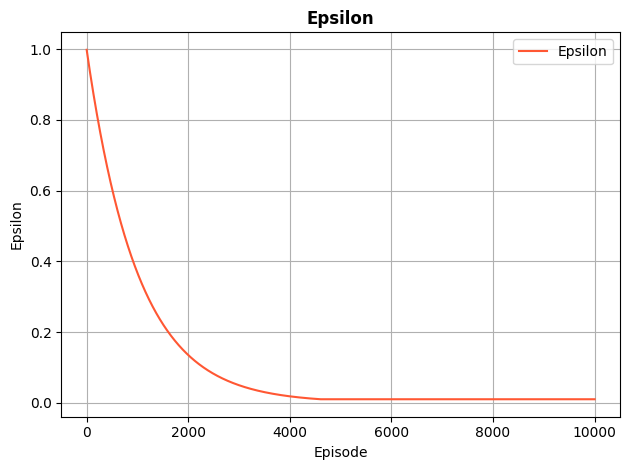

Traning with hyperparams: {'train_episodes': 5000, 'learning_rate': 0.001, 'discount_factor': 0.97}
Episode: 100, Total Steps: 780, Ep Step: 11, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1610, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2333, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3036, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3909, Ep Step: 13, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4714, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5469, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6261, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 7218, Ep Step: 26, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 8192, Ep Step: 27, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 9327, Ep Step: 8, Raw Rewa

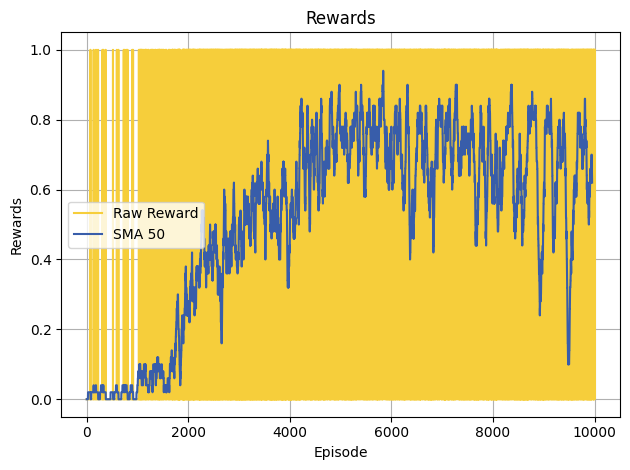

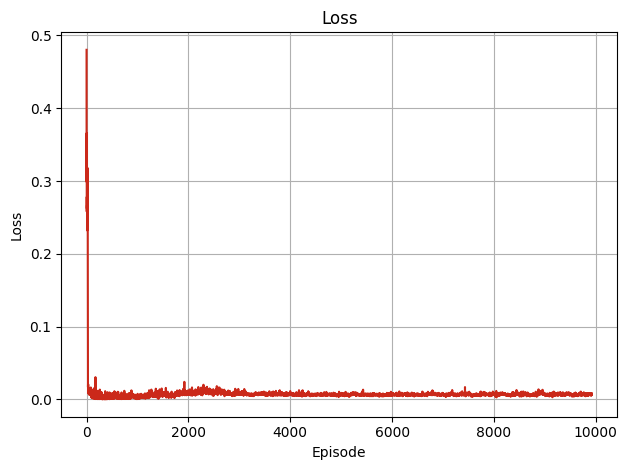

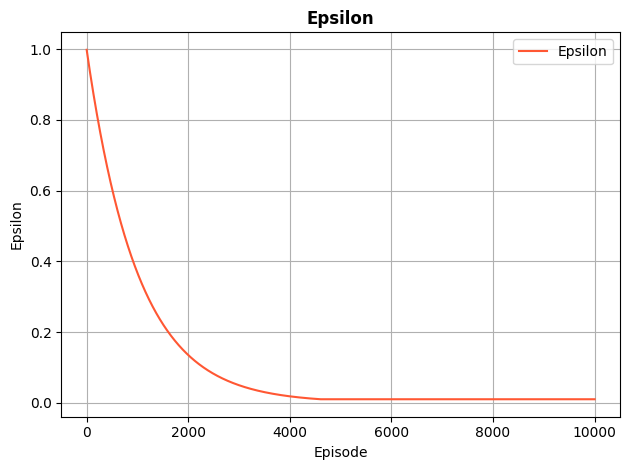

Traning with hyperparams: {'train_episodes': 5000, 'learning_rate': 0.01, 'discount_factor': 0.9}
Episode: 100, Total Steps: 701, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1473, Ep Step: 25, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2253, Ep Step: 12, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 2945, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3738, Ep Step: 13, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4577, Ep Step: 18, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5476, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6267, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 6994, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7864, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8794, Ep Step: 16, Raw Rewa

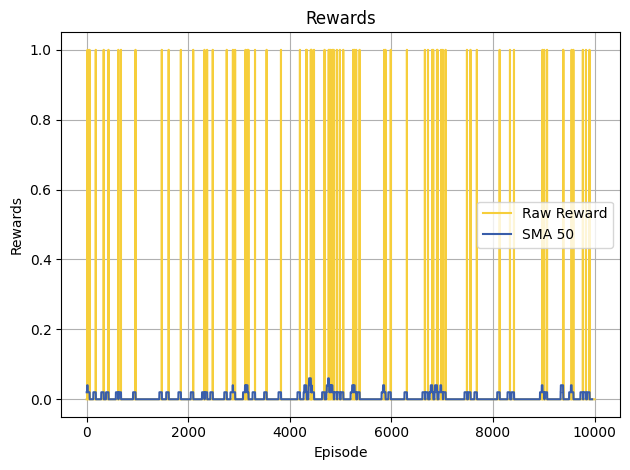

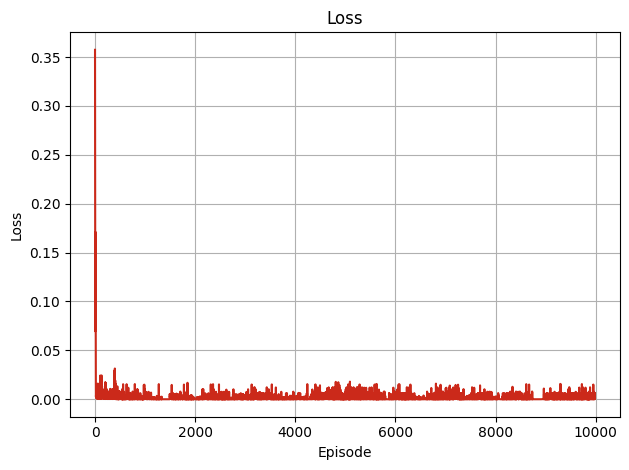

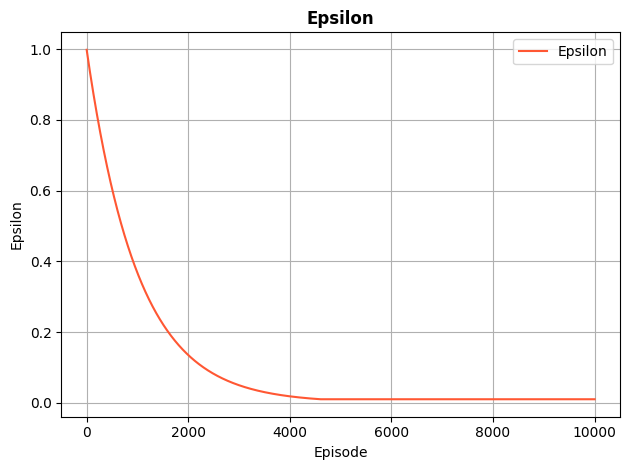

Traning with hyperparams: {'train_episodes': 5000, 'learning_rate': 0.01, 'discount_factor': 0.95}
Episode: 100, Total Steps: 756, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1571, Ep Step: 14, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2307, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3112, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3912, Ep Step: 16, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4755, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5713, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6496, Ep Step: 13, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 7300, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 8067, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8822, Ep Step: 5, Raw Rewar

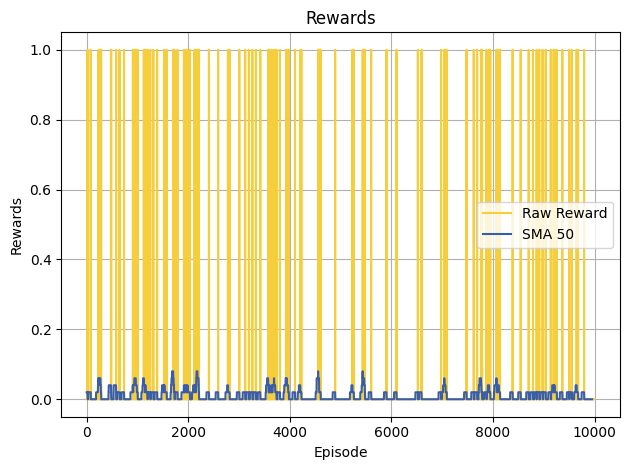

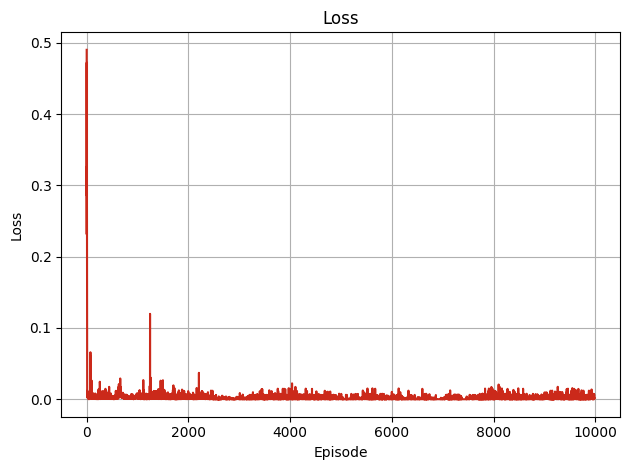

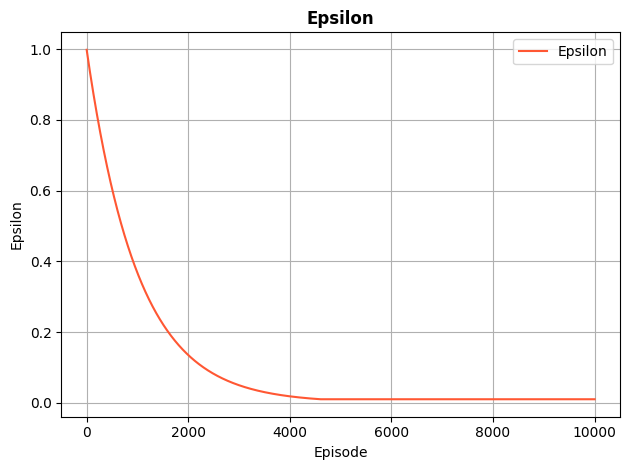

Traning with hyperparams: {'train_episodes': 5000, 'learning_rate': 0.01, 'discount_factor': 0.97}
Episode: 100, Total Steps: 745, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1557, Ep Step: 22, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2294, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 2995, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3904, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4777, Ep Step: 15, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5661, Ep Step: 11, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6593, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 7358, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 8290, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 9075, Ep Step: 5, Raw Reward

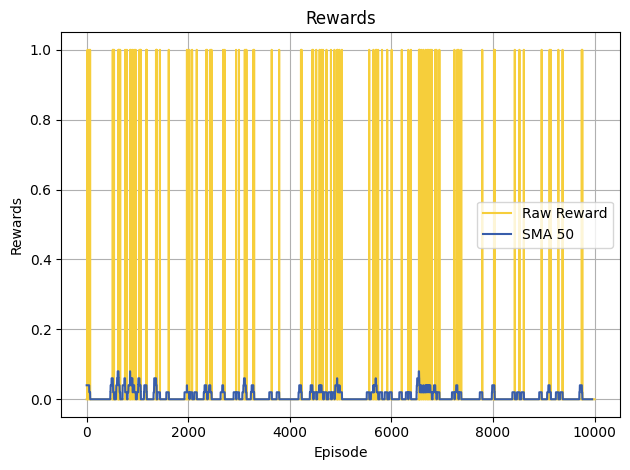

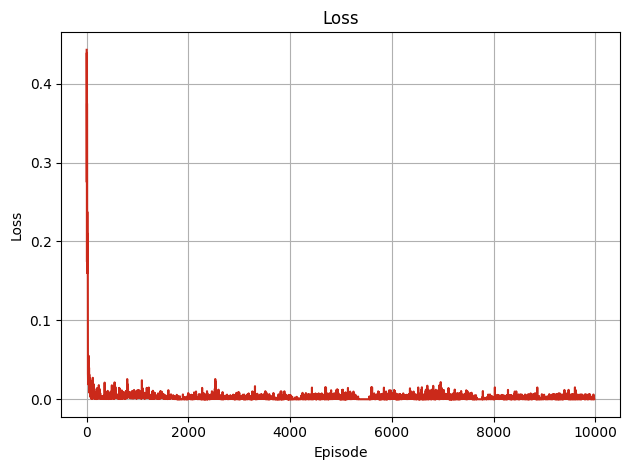

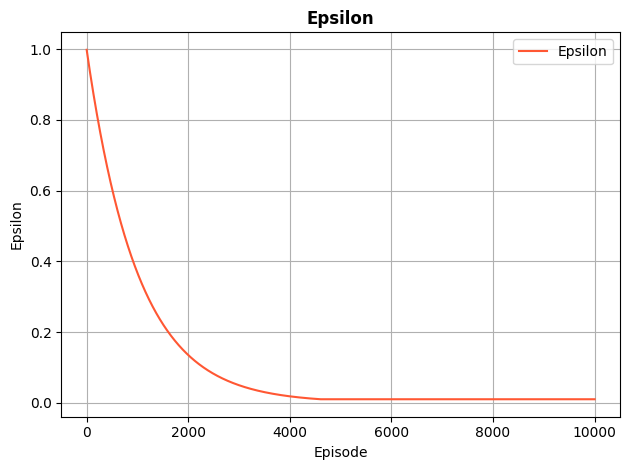

Traning with hyperparams: {'train_episodes': 15000, 'learning_rate': 0.0003, 'discount_factor': 0.9}
Episode: 100, Total Steps: 730, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1395, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2147, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 2890, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3614, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4321, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5070, Ep Step: 13, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 5898, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 6512, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7334, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8224, Ep Step: 4, Raw Rewar

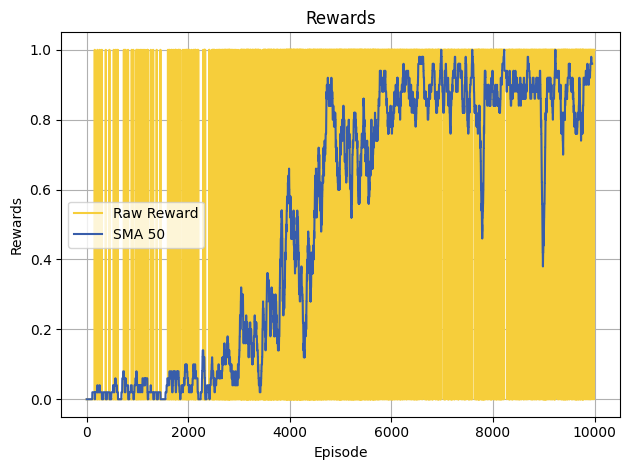

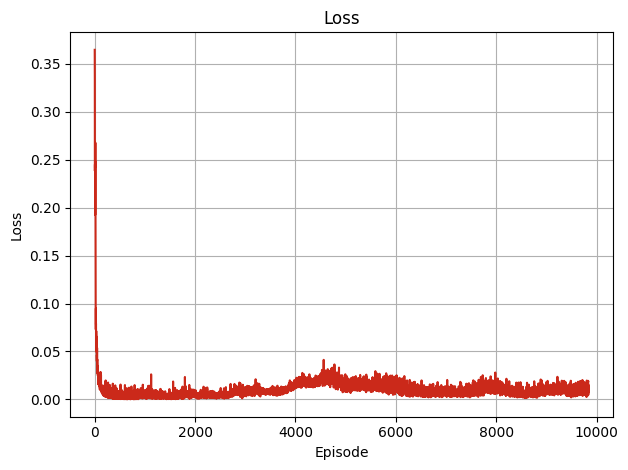

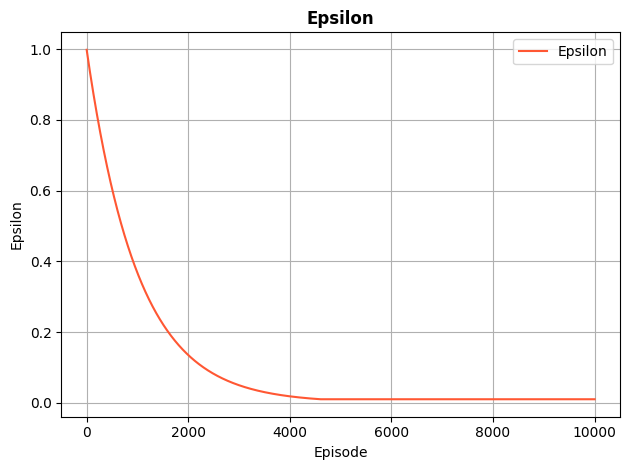

Traning with hyperparams: {'train_episodes': 15000, 'learning_rate': 0.0003, 'discount_factor': 0.95}
Episode: 100, Total Steps: 684, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1486, Ep Step: 19, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2312, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3041, Ep Step: 14, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3782, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4563, Ep Step: 16, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5363, Ep Step: 12, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 6175, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 6987, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7829, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.37
Episode: 1100, Total Steps: 8738, Ep Step: 17, Raw R

In [ ]:
import numpy as np
import itertools

# 参数名和搜索空间
param_names = ["train_episodes","learning_rate","discount_factor"]
param_values = [[2000,5000,15000],[0.0003,0.001,0.01],[0.9,0.95,0.97]]
param_combinations = list(itertools.product(*param_values))

results = []
 
# 进行网格搜索
for params in param_combinations:
    # 解包参数
    hyperparams = dict(zip(param_names,params))
    print(F"Traning with hyperparams: {hyperparams}")
    # 更新参数
    config.update(hyperparams)
    # 创建新坏境
    env = gym.make(
        'FrozenLake-v1',
        map_name = f"{config['map_size']}x{config['map_size']}",
        is_slippery = True,
        max_episode_steps = config['max_steps']
    )
    env.reset(seed=config.get('seed', 0))
    env.action_space.seed(config.get('seed', 0))
    
    # 创建代理和训练器
    agent = DQNAgent(env, config)
    trainer = Trainer(env, agent, config)
    # 训练并记录结果
    trainer.train()
    avg_reward = np.mean(trainer.reward_history[-100:])  # 最近 100 个 episode 的平均奖励
    results.append((hyperparams, avg_reward))

# 输出最佳超参数组合和对应的平均奖励
best_params = max(results, key=lambda x: x[1])
print(f"Best hyperparams: {best_params[0]} with average reward: {best_params[1]:.2f}")



## 随机参数调整
由于组合参数调优需要消耗大量时间，我选择使用随机参数调优的方式

In [ ]:
import numpy as np
import itertools
import random

# 参数名和搜索空间
param_names = ["train_episodes","learning_rate","discount_factor", "update_frequency"]
param_values = [random.choice([2000,5000,15000]),random.choice([0.0003,0.001,0.01]),random.choice([0.9,0.95,0.97]),random.choice([10,15,20])]
results = []
param_values = [10000, 0.0003, 0.97, 10]
# 解包参数
hyperparams = dict(zip(param_names,param_values))
print(F"Traning with hyperparams: {hyperparams}")
# 更新参数
config.update(hyperparams)

# 创建新坏境
env = gym.make(
    'FrozenLake-v1',
    map_name = f"{config['map_size']}x{config['map_size']}",
    is_slippery = True,
    max_episode_steps = config['max_steps']
)

# 创建代理和训练器
agent = DQNAgent(env, config)
trainer = Trainer(env, agent, config)
# 训练并记录结果
trainer.train()
avg_reward = np.mean(trainer.reward_history[-100:])  # 最近 100 个 episode 的平均奖励
results.append((hyperparams, avg_reward))

# 输出最佳超参数组合和对应的平均奖励
best_params = max(results, key=lambda x: x[1])
print(f"Best hyperparams: {best_params[0]} with average reward: {best_params[1]:.2f}")



Traning with hyperparams: {'train_episodes': 10000, 'learning_rate': 0.0003, 'discount_factor': 0.97, 'update_frequency': 10}
train with episodes: 10000
Episode: 100, Total Steps: 757, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1514, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2288, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 2973, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 3716, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 4343, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 5071, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 5728, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 6421, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 7155, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.37
